# Scaled Dot-product Attention Mechanism

In the previous notebook, titled [Self-Attention Part 1](https://github.com/AnkitaMungalpara/Building-LLM-From-Scratch/blob/main/01_Self_Attention_In_Work_Part_1.ipynb), we implemented a simplified attention mechanism without any trainable weights.

In this notebook, we will take it a step further by implementing self-attention with trainable weights.

Let's see how it works!

## Computing the attention weights step by step


To compute the attention weights step by step, let's first introduce the concepts clearly, and then work through an example.

We have three trainable weight matrices: `Wq, Wk, and Wv`. These matrices are responsible for projecting the embedded input tokens into query, key, and value vectors, respectively.


In [2]:
import torch
inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55]] # step     (x^6)
)

In [3]:
inputs.shape

torch.Size([6, 3])

### Query, Key and Value Vectors

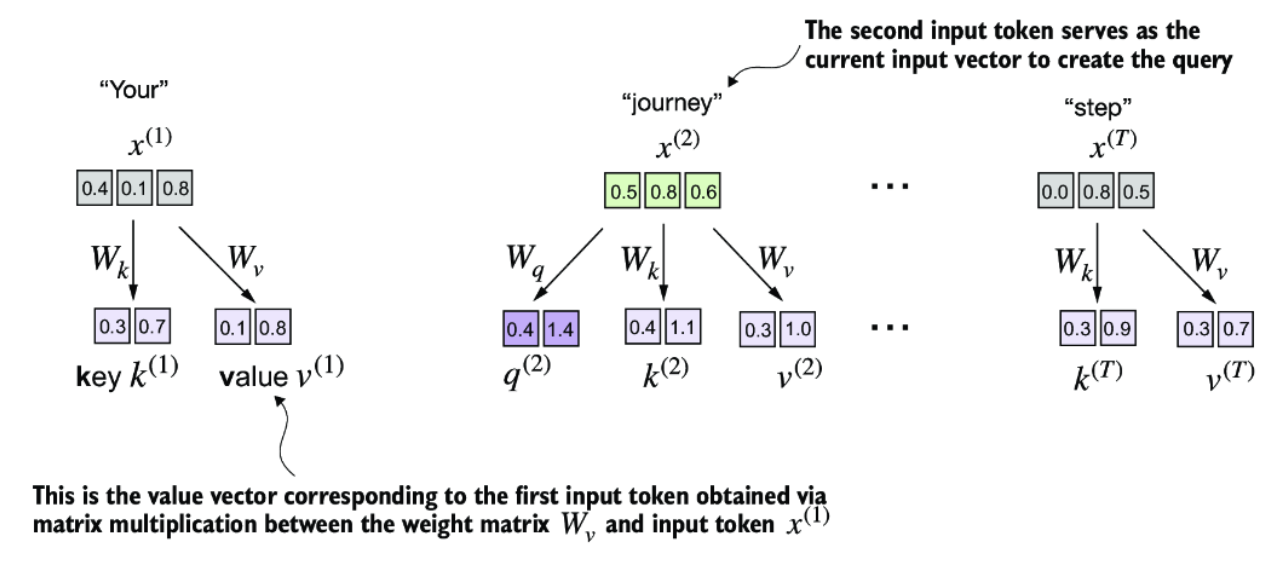

Credit:  [Build a Large Language Model (From Scratch)](https://www.manning.com/books/build-a-large-language-model-from-scratch)

Lets' define few variables:

In [4]:
x_2 = inputs[1]
d_in = inputs.shape[1]
d_out = 2

Now, we will initalize three weight matrices `Wq, Wk, and Wv`.

In [5]:
torch.manual_seed(42)
w_query = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
w_key = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
w_value = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)

In [6]:
w_query.shape

torch.Size([3, 2])

Next, we compute query, key and value matrices for second input:


In [7]:
query_2 = x_2 @ w_query
key_2 = x_2 @ w_key
value_2 = x_2 @ w_value

In [8]:
query_2

tensor([1.0760, 1.7344])


Weight parameters in weight matrices are fundamental, learned coefficients that define the network connections, while attention weights are dynamic and context-specific values.

Next, we will obtain all the keys and values by performing matrix multiplication.

In [9]:
keys = inputs @ w_key
values = inputs @ w_value

In [10]:
keys.shape, values.shape

(torch.Size([6, 2]), torch.Size([6, 2]))

### Attention Score

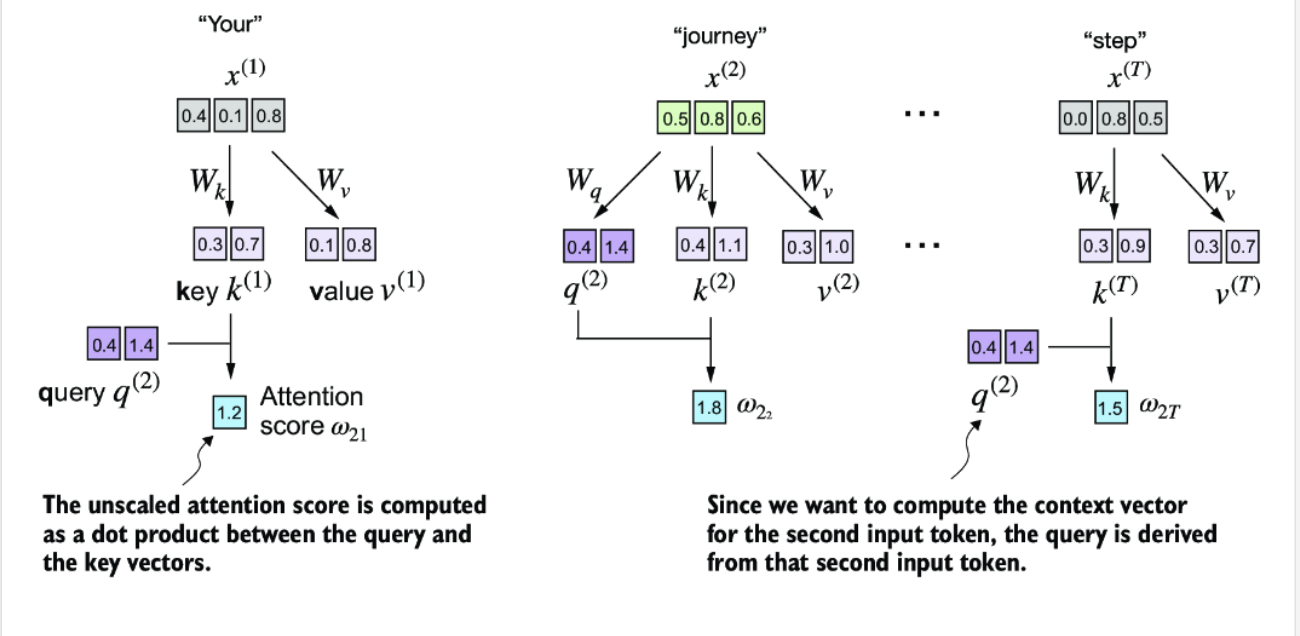

Credit:  [Build a Large Language Model (From Scratch)](https://www.manning.com/books/build-a-large-language-model-from-scratch)

Next, we compute attention score `w22`.

In [11]:
keys_2 = keys[1]
attention_score_22 = query_2.dot(key_2)

In [12]:
attention_score_22

tensor(3.3338)

Also, we can generalize this computation to all attention scores by doing matrix multiplication:

In [13]:
attention_score_2 = query_2 @ keys.T

In [14]:
attention_score_2

tensor([2.7084, 3.3338, 3.3013, 1.7563, 1.7869, 2.1966])

### Attention Weight

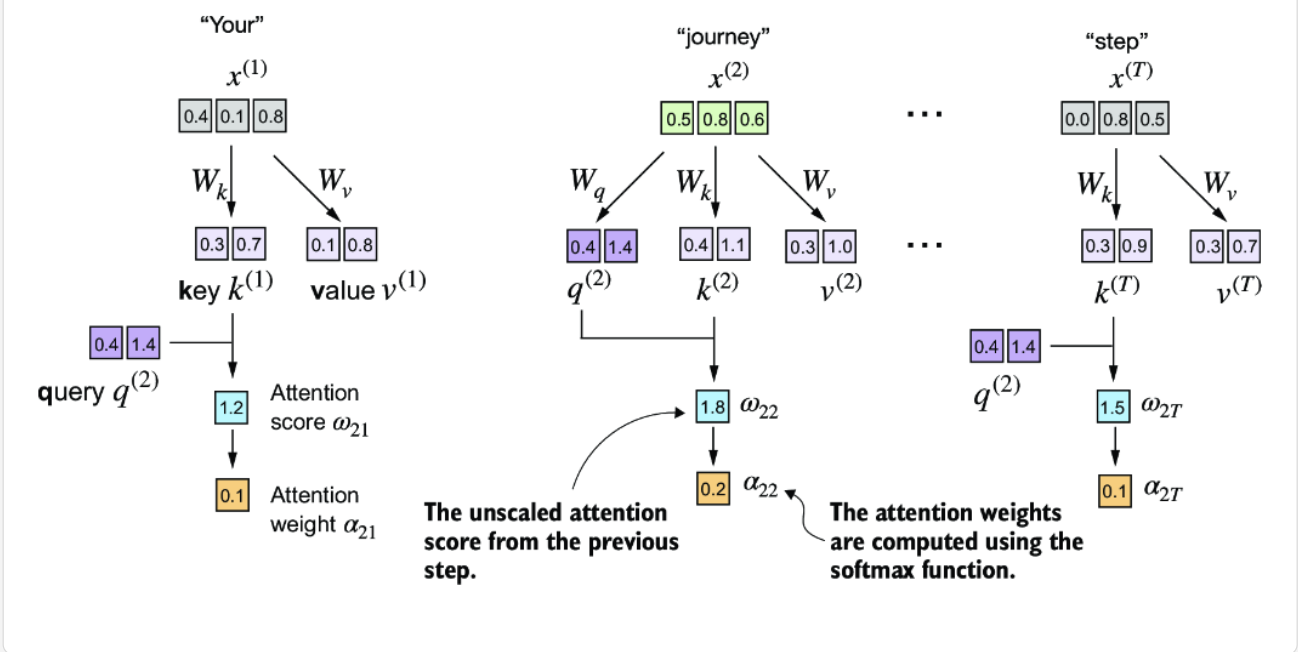

Credit:  [Build a Large Language Model (From Scratch)](https://www.manning.com/books/build-a-large-language-model-from-scratch)

Now, we compute **attention weights** by calling attention scores and using the softmax function. However, we scale the attention scores by dividing them by the square root of the embedding dimension of the keys.

In [15]:
keys.shape

torch.Size([6, 2])

In [16]:
d_k = keys.shape[-1]
attention_weights_2 = torch.softmax(attention_score_2 / d_k**0.5, dim=-1)

In [17]:
attention_weights_2

tensor([0.1723, 0.2681, 0.2620, 0.0879, 0.0898, 0.1200])

The scaling mechanism by the square root of the embedding dimension is the reason why self-attention is called the **scaled dot product** mechanism.

### Context Vector

Now it's time to compute context vectors. It is represented as a weighted sum over input vectors. We will compute the context vector as a weighted sum over the value vectors.

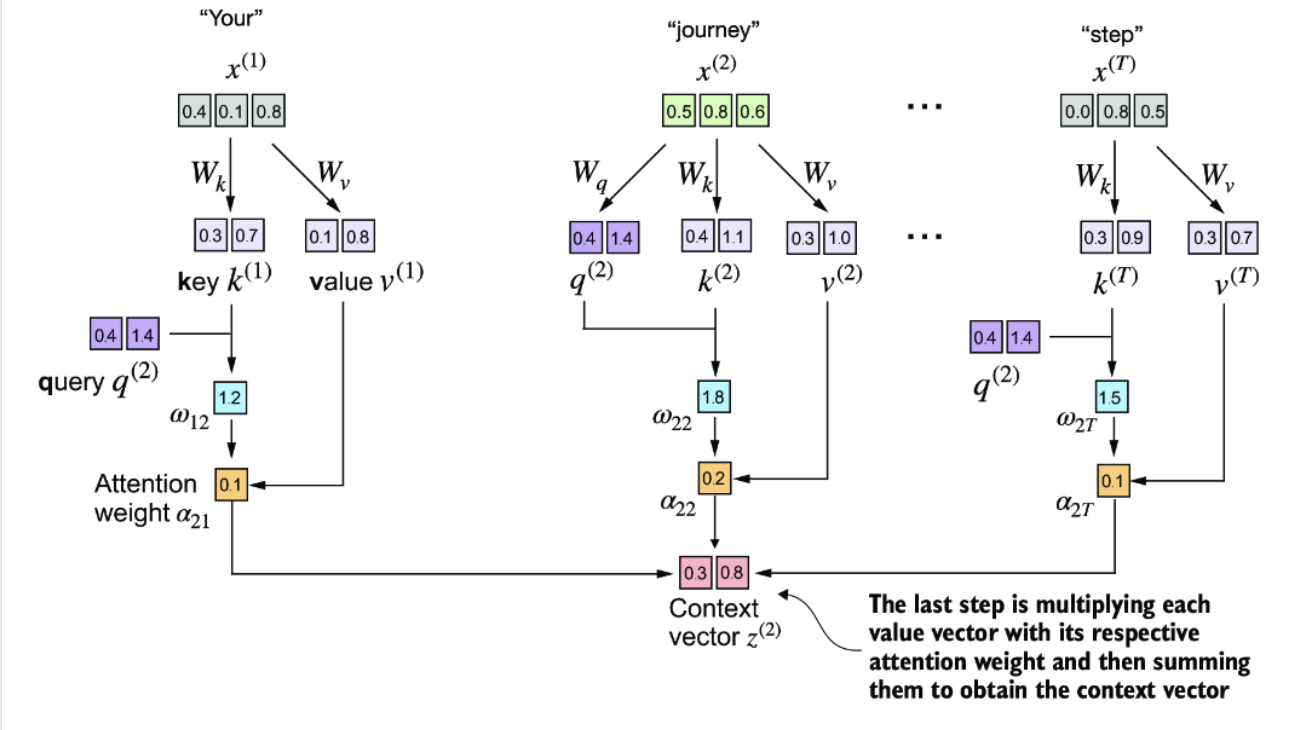

Credit:  [Build a Large Language Model (From Scratch)](https://www.manning.com/books/build-a-large-language-model-from-scratch)

In [18]:
context_vec_2 = attention_weights_2 @ values

In [19]:
context_vec_2

tensor([1.4201, 0.8892])

## Implementing Compact SelfAttention Class

In [20]:
import torch.nn as nn

Next, we will define a Python class called `SelfAttention_v1`. This class implements the self-attention mechanism using PyTorch's `nn.Parameter` to store the weight matrices (query, key, and value). The `forward` method shows how these weights are used to compute attention scores, weights, and context vectors.

In [21]:
class SelfAttention_v1(nn.Module):

  def __init__(self, d_in, d_out):
    super().__init__()
    self.W_query = nn.Parameter(torch.randn(d_in, d_out))
    self.W_key = nn.Parameter(torch.randn(d_in, d_out))
    self.W_value = nn.Parameter(torch.randn(d_in, d_out))

  def forward(self, x):
    keys = x @ self.W_key
    queries = x @ self.W_query
    values = x @ self.W_value

    attention_scores = queries @ keys.T
    attention_weights = torch.softmax(
        attention_scores / keys.shape[-1] ** 0.5, dim = -1
    )

    context_vector = attention_weights @ values
    return context_vector

In [23]:
torch.manual_seed(123)
self_attention_v1 = SelfAttention_v1(d_in, d_out)
print(self_attention_v1(inputs))

tensor([[0.2845, 0.4071],
        [0.2854, 0.4081],
        [0.2854, 0.4075],
        [0.2864, 0.3974],
        [0.2863, 0.3910],
        [0.2860, 0.4039]], grad_fn=<MmBackward0>)


Now, we will define a new class `SelfAttention_v2` that is similar to `SelfAttention_v1` but uses `nn.Linear` layers for the query, key, and value transformations. It also includes an option for bias in these linear layers.

In [24]:
class SelfAttention_v2(nn.Module):

  def __init__(self, d_in, d_out, qkv_bias = False):
    super().__init__()
    self.W_query = nn.Linear(d_in, d_out, bias = qkv_bias)
    self.W_key = nn.Linear(d_in, d_out, bias = qkv_bias)
    self.W_value = nn.Linear(d_in, d_out, bias = qkv_bias)

  def forward(self, x):
    keys    = self.W_key(x)
    queries = self.W_query(x)
    values  = self.W_value(x)

    attention_scores = queries @ keys.T
    attention_weights = torch.softmax(
        attention_scores / keys.shape[-1] ** 0.5, dim = -1
    )

    context_vector = attention_weights @ values
    return context_vector

In [25]:
torch.manual_seed(768)
self_attention_v2 = SelfAttention_v2(d_in, d_out)
print(self_attention_v2(inputs))

tensor([[-0.0256, -0.0702],
        [-0.0175, -0.0742],
        [-0.0175, -0.0744],
        [-0.0177, -0.0735],
        [-0.0187, -0.0765],
        [-0.0175, -0.0721]], grad_fn=<MmBackward0>)


Notice that `SelfAttention_v1` and `SelfAttention_v2` produce different outputs because they are initialized with different weight matrices.

# Hiding future words with casual attention

## Applying casual attention mask

To implement casual self-sttention, let's work with attention scores and weights from the previous section:


In [26]:
# Reuse the query and key weight matrices of the
# SelfAttention_v2 object from the previous section for convenience

queries = self_attention_v2.W_query(inputs)
keys = self_attention_v2.W_key(inputs)

attention_scores = queries @ keys.T
attention_weights = torch.softmax(
    attention_scores / keys.shape[-1] ** 0.5, dim = -1
    )
print(attention_weights)

tensor([[0.1546, 0.1686, 0.1686, 0.1703, 0.1673, 0.1706],
        [0.1741, 0.1653, 0.1653, 0.1649, 0.1653, 0.1651],
        [0.1742, 0.1652, 0.1651, 0.1651, 0.1648, 0.1656],
        [0.1731, 0.1658, 0.1659, 0.1644, 0.1672, 0.1637],
        [0.1737, 0.1636, 0.1631, 0.1691, 0.1561, 0.1744],
        [0.1722, 0.1667, 0.1671, 0.1624, 0.1722, 0.1593]],
       grad_fn=<SoftmaxBackward0>)


### using `Torch.tril`

In [28]:
context_length = attention_scores.shape[0]
mask_simple = torch.tril(
    torch.ones(context_length, context_length)
)
print(mask_simple)

tensor([[1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1.]])


In [29]:
masked_simple = attention_weights * mask_simple
print(masked_simple)

tensor([[0.1546, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1741, 0.1653, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1742, 0.1652, 0.1651, 0.0000, 0.0000, 0.0000],
        [0.1731, 0.1658, 0.1659, 0.1644, 0.0000, 0.0000],
        [0.1737, 0.1636, 0.1631, 0.1691, 0.1561, 0.0000],
        [0.1722, 0.1667, 0.1671, 0.1624, 0.1722, 0.1593]],
       grad_fn=<MulBackward0>)


To ensure that each row sums to 1, we normalize the attention weights as follows:

In [32]:
row_sums = masked_simple.sum(dim=-1, keepdim=True)
masked_simple_norm = masked_simple / row_sums
print(masked_simple_norm)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5130, 0.4870, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3453, 0.3274, 0.3273, 0.0000, 0.0000, 0.0000],
        [0.2586, 0.2478, 0.2479, 0.2457, 0.0000, 0.0000],
        [0.2104, 0.1982, 0.1975, 0.2048, 0.1890, 0.0000],
        [0.1722, 0.1667, 0.1671, 0.1624, 0.1722, 0.1593]],
       grad_fn=<DivBackward0>)


Instead of zeroing out the attention weights above the diagonal and then renormalizing, we can apply a causal mask before the softmax by setting the unnormalized attention scores above the diagonal to negative infinity. This ensures that the softmax operation naturally assigns zero probability to those masked positions.

In [34]:
mask = torch.triu(
    torch.ones(context_length, context_length), diagonal=1)

tensor([[0., 1., 1., 1., 1., 1.],
        [0., 0., 1., 1., 1., 1.],
        [0., 0., 0., 1., 1., 1.],
        [0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0.]])


In [36]:
masked = attention_scores.masked_fill(mask.bool(), -torch.inf)
print(masked)

tensor([[-0.1101,    -inf,    -inf,    -inf,    -inf,    -inf],
        [ 0.0592, -0.0141,    -inf,    -inf,    -inf,    -inf],
        [ 0.0569, -0.0181, -0.0186,    -inf,    -inf,    -inf],
        [ 0.0615,  0.0007,  0.0014, -0.0112,    -inf,    -inf],
        [-0.0016, -0.0861, -0.0909, -0.0399, -0.1530,    -inf],
        [ 0.0848,  0.0392,  0.0422,  0.0024,  0.0853, -0.0248]],
       grad_fn=<MaskedFillBackward0>)


In [37]:
attention_weights = torch.softmax(
    masked / keys.shape[-1]**0.5, dim=-1
)
print(attention_weights)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5130, 0.4870, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3453, 0.3274, 0.3273, 0.0000, 0.0000, 0.0000],
        [0.2586, 0.2478, 0.2479, 0.2457, 0.0000, 0.0000],
        [0.2104, 0.1982, 0.1975, 0.2048, 0.1890, 0.0000],
        [0.1722, 0.1667, 0.1671, 0.1624, 0.1722, 0.1593]],
       grad_fn=<SoftmaxBackward0>)
